# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [142]:
# import libraries
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.functions import asc, col, datediff, dayofmonth, desc, from_unixtime
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import udf
from pyspark.sql.types import DateType, IntegerType, StringType,DecimalType, DoubleType


%matplotlib inline
plt.style.use('seaborn-darkgrid')
sns.set(style="darkgrid")

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '38237'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', 'mint.lan'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.id', 'local-1592586797596')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## Load Data

In [4]:
file_path = "./mini_sparkify_event_data.json"
df = spark.read.json(file_path)

## Clean Data

### Explore Data

In [5]:
# display columns names
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# size of the data
df.count(), len(df.columns)

(286500, 18)

In [7]:
# display first 5 record
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [8]:
# check null values
for col in df.columns:
    print(col, "\t", "with null values:", df.filter(df[col].isNull()).count())

artist 	 with null values: 58392
auth 	 with null values: 0
firstName 	 with null values: 8346
gender 	 with null values: 8346
itemInSession 	 with null values: 0
lastName 	 with null values: 8346
length 	 with null values: 58392
level 	 with null values: 0
location 	 with null values: 8346
method 	 with null values: 0
page 	 with null values: 0
registration 	 with null values: 8346
sessionId 	 with null values: 0
song 	 with null values: 58392
status 	 with null values: 0
ts 	 with null values: 0
userAgent 	 with null values: 8346
userId 	 with null values: 0


Exam columns with Null Values

In [9]:
# null values due to empty userId
df.select("userId","firstName","lastName", "location", "registration", "userAgent").where(F.col("firstName").isNull()).show()

+------+---------+--------+--------+------------+---------+
|userId|firstName|lastName|location|registration|userAgent|
+------+---------+--------+--------+------------+---------+
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|        null|     null|
|      |     null|    null|    null|    

In [10]:
# null values due to activities (page visited) not related to song playing 
df.select("userId", "page","artist","length", "song").where(F.col("artist").isNull()).show()

+------+---------------+------+------+----+
|userId|           page|artist|length|song|
+------+---------------+------+------+----+
|    30|Add to Playlist|  null|  null|null|
|     9|    Roll Advert|  null|  null|null|
|     9|      Thumbs Up|  null|  null|null|
|    54|      Downgrade|  null|  null|null|
|    54|      Thumbs Up|  null|  null|null|
|     9|    Thumbs Down|  null|  null|null|
|     9|           Home|  null|  null|null|
|     9|         Logout|  null|  null|null|
|    74|      Thumbs Up|  null|  null|null|
|      |           Home|  null|  null|null|
|      |           Help|  null|  null|null|
|      |           Home|  null|  null|null|
|      |          Login|  null|  null|null|
|     9|           Home|  null|  null|null|
|    30|    Thumbs Down|  null|  null|null|
|     4|         Logout|  null|  null|null|
|      |           Home|  null|  null|null|
|      |          Login|  null|  null|null|
|     4|           Home|  null|  null|null|
|    74|Add to Playlist|  null| 

The null values in the `artist`, `length` and `song` columns corresponds to actions not related to playing a song.

### Clean Data

In [11]:
# exam and make sure we have valid userId for all records
df.select("userId").distinct().sort(asc("userId")).show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [12]:
# remove data where userID is empty string
df = df.filter("userId != ''")

In [13]:
# shape of cleaned data
df.count(), len(df.columns)

(278154, 18)

# Exploratory Data Analysis

##  Define Churn

In [14]:
# list of events in page column
df.select("page").distinct().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



We will use the `Cancellation Confirmation` event in the `page` column to define churn, which happen for both paid and free users.

In [15]:
def get_churn(df=df):
    df.createOrReplaceTempView("df")
    # query a table with churned userId and value 1 indicating they are churned user
    churned_userId = spark.sql(
        'SELECT DISTINCT userId, 1 as churn FROM df \
    WHERE page = "Cancellation Confirmation"'
    )
    # query a table with churned userId and value 0 indicating they are churned user
    unchurned_userId = spark.sql(
        'SELECT DISTINCT userId, 0 as churn FROM df \
    WHERE userId NOT IN (SELECT DISTINCT userId from df WHERE Page = "Cancellation Confirmation")'
    )
    # merge two table together
    return churned_userId.union(unchurned_userId)


assert get_churn(df).count() == df.select("userId").distinct().count()

In [16]:
# Data preparation
churn_df = get_churn(df)
data = churn_df.toPandas()
counts = data["churn"].value_counts()
total = len(data)
labels = ["Active", "Churned"]

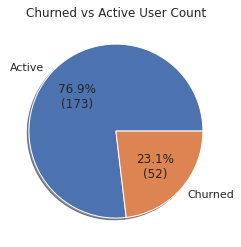

In [17]:
def my_fmt(x):
    """autopct formatter to display both actual value and percentage"""
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)
                                      
# Draw Plot
plt.pie(counts, labels = labels, autopct = my_fmt, shadow=True)
plt.title("Churned vs Active User Count");

## User Life Time 

In [18]:
def get_days_since_reg(df=df):
    """
    Returns the number of days since registration for each user
    """

    time_df = df.groupby("userId").agg(
        F.expr("from_unixtime(min(registration)/1000)").alias("reg_time"),
        F.expr("from_unixtime(max(ts)/1000)").alias("last_active_time"),
    )

    return time_df.withColumn(
        "days_since_reg", F.datediff(F.col("last_active_time"), F.col("reg_time"))
    ).select("userId", "days_since_reg")

In [40]:
# Data Preparation
life_df= get_days_since_reg(df)
data = life_df.join(churn_df, on=['userId']).toPandas()

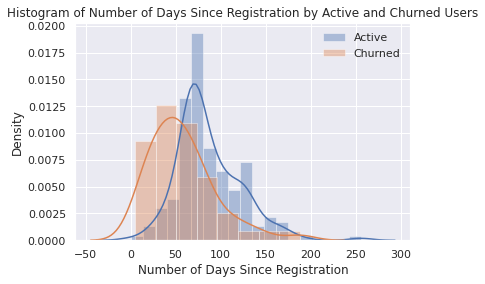

In [45]:
# Plot
sns.distplot(data[data["churn"] ==0]["days_since_reg"], kde =True, label = "Active")
sns.distplot(data[data["churn"] ==1]["days_since_reg"], kde =True, label = "Churned")
plt.xlabel("Number of Days Since Registration")
plt.ylabel("Density")
plt.title("Histogram of Number of Days Since Registration by Active and Churned Users")
plt.legend();

## User Gender

In [21]:
def get_gender(df = df):
    """
    Query and return the gender of each user
    """ 
    
    gender_df = df.groupby("userId").agg(Fmax("gender").alias('gender'))
    
    return gender_df

Text(0, 0.5, 'Count')

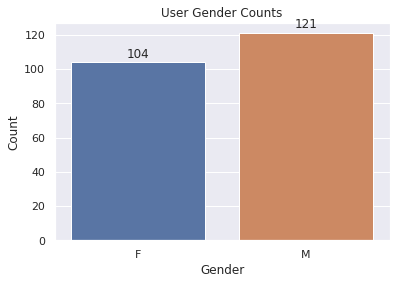

In [22]:
# create gender by userId dataframe
gender_df=get_gender(df)
# create gender counts df
data = gender_df.groupby("gender").agg(F.expr("count(userId)").alias("count")).toPandas()

# Plot gender counts df
ax = sns.barplot(x = "gender", y = "count", data = data)
# Annotations
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.0,
        height + 3,
        "{:.0f}".format(height),
        ha="center",
    )
plt.title("User Gender Counts")
plt.xlabel("Gender")
plt.ylabel("Count")

User Gender by Churn

In [23]:
data = gender_df.join(churn_df, on=["userId"]).toPandas()
data['churn'] = data['churn'].map({0:"Active", 1:"Churn"})

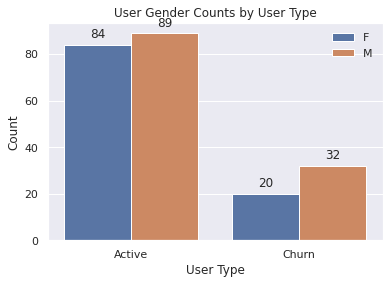

In [24]:
ax = sns.countplot(x="churn", hue="gender", data=data)
ax.legend().set_title("")

# Annotations
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.0,
        height + 3,
        "{:.0f}".format(height),
        ha="center",
    )
plt.title("User Gender Counts by User Type")
plt.xlabel("User Type")
plt.ylabel("Count");

## User Activity

### Unique Sessions

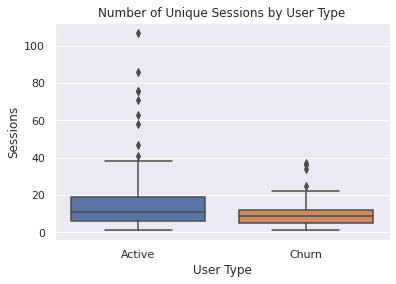

In [25]:
session_df = df.groupby("userId").agg(F.expr("count(distinct(sessionId))").alias("sessions"))
data = session_df.join(churn_df, on = ["userId"]).toPandas()
data['churn'] = data['churn'].map({0:"Active", 1:"Churn"})

ax = sns.boxplot(x="churn",y="sessions", data=data)
ax.set_title("Number of Unique Sessions by User Type")
ax.set_xlabel("User Type")
ax.set_ylabel("Sessions");

### Friend Added

In [52]:
def get_user_action_count(action, alias, df=df):
    """Query and return the count of specific action by each user"""

    return (
        df.select("userId", "page")
        .filter("page = '{}'".format(action))
        .groupby("userId")
        .agg(F.expr("count(page)").alias(alias))
    )

In [99]:
def action_distplot(action,kde_bol = True, alias="a", df=df, churn_df=churn_df):
    """plot the distribution of specific number of actions per active vs. churned user """

    # Data preparation

    temp_df = get_user_action_count(action, alias, df)
    data = temp_df.join(churn_df, on=["userId"]).toPandas()

    # Plot
    sns.distplot(data[data["churn"] ==0][alias], kde =kde_bol, label = "Active")
    sns.distplot(data[data["churn"] ==1][alias], kde =kde_bol, label = "Churned")
    plt.xlabel(f"Action Count - {action}")
    if kde_bol:
        plt.ylabel("Density")
    else:
        plt.ylabel("Count") 
    plt.title(f"Distribution of Action Count by Active and Churned Users - {action}")
    plt.legend()

In [178]:
def describe_action(action, df=df, churn_df=churn_df):
    action_df = get_user_action_count(action, "v", df)
    data = action_df.join(churn_df, on=["userId"])
    return data.groupby("churn").agg(
        F.count("v").alias("count"),
        F.format_number(F.mean("v"),1).alias("mean"),
        F.format_number(F.stddev("v"),1).alias("std"),
        F.min("v").alias("min"),
        F.format_number(F.expr("percentile(v, array(0.25))")[0],1).alias("%25"),
        F.format_number(F.expr("percentile(v, array(0.5))")[0],1).alias("%50"),
        F.format_number(F.expr("percentile(v, array(0.75))")[0],1).alias("%75"),
        F.max("v").alias("max"),
    )

In [179]:
describe_action("Add Friend").show()

+-----+-----+----+----+---+---+----+----+---+
|churn|count|mean| std|min|%25| %50| %75|max|
+-----+-----+----+----+---+---+----+----+---+
|    1|   44|14.5|10.7|  1|6.0|12.5|21.2| 47|
|    0|  162|22.5|22.3|  1|8.0|17.0|31.0|143|
+-----+-----+----+----+---+---+----+----+---+



In [180]:
action_list = df.select("page").distinct().toPandas().iloc[:,0]
for action in action_list:
    print(f"Statistics of {action}:")
    describe_action(action).show()
    

Statistics of Cancel:
+-----+-----+----+---+---+---+---+---+---+
|churn|count|mean|std|min|%25|%50|%75|max|
+-----+-----+----+---+---+---+---+---+---+
|    1|   52| 1.0|0.0|  1|1.0|1.0|1.0|  1|
+-----+-----+----+---+---+---+---+---+---+

Statistics of Submit Downgrade:
+-----+-----+----+---+---+---+---+---+---+
|churn|count|mean|std|min|%25|%50|%75|max|
+-----+-----+----+---+---+---+---+---+---+
|    1|    9| 1.0|0.0|  1|1.0|1.0|1.0|  1|
|    0|   40| 1.4|0.6|  1|1.0|1.0|2.0|  3|
+-----+-----+----+---+---+---+---+---+---+

Statistics of Thumbs Down:
+-----+-----+----+----+---+---+---+----+---+
|churn|count|mean| std|min|%25|%50| %75|max|
+-----+-----+----+----+---+---+---+----+---+
|    1|   48|10.3| 9.0|  1|3.0|8.0|16.0| 36|
|    0|  155|13.2|14.2|  1|3.5|9.0|17.0| 75|
+-----+-----+----+----+---+---+---+----+---+

Statistics of Home:
+-----+-----+----+----+---+----+----+----+---+
|churn|count|mean| std|min| %25| %50| %75|max|
+-----+-----+----+----+---+----+----+----+---+
|    1|   51

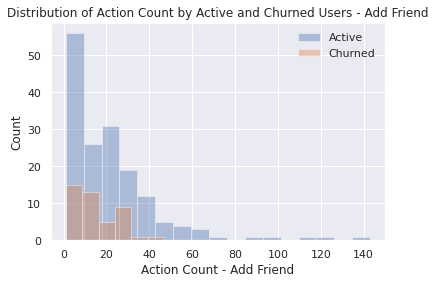

In [100]:
action_distplot("Add Friend", False)

### Thumbs Down

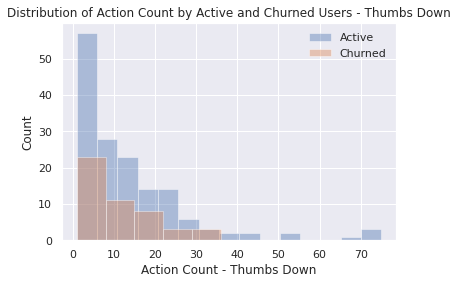

In [102]:
action_distplot("Thumbs Down",False)

In [29]:
df.select("page").distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.